## Utilisation du dataset minst

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Charger dataset MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Préparer les données
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Création du modèle CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.summary()

# Compilation le modèle
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(x_train, y_train, epochs=5, batch_size=64,
                    validation_data=(x_test, y_test), verbose=1)

# Évaluation du modèle
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Précision sur MNIST : {test_accuracy:.2%}")

# Sauvegarde du modèle
model.save('mnist_base_model.h5')
print("Modèle sauvegardé sous 'mnist_base_model.h5'")

11490434/11490434 [==============================] - 3s 0us/step
Epoch 1/5
938/938 [==============================] - 24s 23ms/step - loss: 0.2324 - accuracy: 0.9302 - val_loss: 0.0503 - val_accuracy: 0.9837
Epoch 2/5
938/938 [==============================] - 20s 22ms/step - loss: 0.0793 - accuracy: 0.9764 - val_loss: 0.0354 - val_accuracy: 0.9880
Epoch 3/5
938/938 [==============================] - 26s 28ms/step - loss: 0.0581 - accuracy: 0.9830 - val_loss: 0.0309 - val_accuracy: 0.9895
Epoch 4/5
938/938 [==============================] - 22s 23ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.0256 - val_accuracy: 0.9902
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 0.0243 - accuracy: 0.9919
Précision sur MNIST : 99.19%


c:\Master\Semestre 2\PI\Projet\.venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Modèle sauvegardé sous 'mnist_base_model.h5'


### Test du model cré avec le dataset minst

In [6]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image

# Charger le modèle une seule fois au niveau global
model = load_model('mnist_base_model.h5')

def predict_digit_from_image(image_path):
    """
    Prédit le chiffre sur une image binarisée (fond blanc, chiffre noir).
    :param image_path: chemin vers l'image
    :return: chiffre prédit (int)
    """
    # Charger et convertir l'image en niveaux de gris
    img = Image.open(image_path).convert('L')
    
    # Redimensionner à 28x28
    img = img.resize((28, 28))

    # Convertir en tableau numpy et normaliser
    img_array = np.array(img).astype('float32') / 255.0

    # Formater pour le modèle (1, 28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    # Prédire
    prediction = model.predict(img_array, verbose=0)
    predicted_digit = int(np.argmax(prediction))

    return predicted_digit

chemin_image = "image.png"
chiffre = predict_digit_from_image(chemin_image)
print(f"Chiffre prédit : {chiffre}")


Chiffre prédit : 6


### detection et extraction des positions

In [ ]:
import cv2
import json

positions = []

# Callback pour gérer les clics souris
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        w, h = 28, 28  # Taille du ROI
        positions.append((x, y, w, h))
        print(f"Position enregistrée : x={x}, y={y}, w={w}, h={h}")
        cv2.rectangle(img_display, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow(window_name, img_display)

# --- Charge l'image binarisée du décalque ---
image_path = "dataset_binarized/train/conformes/30mm_WonB_1_resized_copy1_copy1_copy1.jpg"
img = cv2.imread(image_path)

if img is None:
    raise FileNotFoundError(f"L'image '{image_path}' n'a pas été trouvée.")

img_display = img.copy()

# --- Crée une fenêtre redimensionnable ---
window_name = "Clique sur les chiffres"
cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
cv2.imshow(window_name, img_display)
cv2.setMouseCallback(window_name, click_event)

print("🖱️ Clique sur chaque chiffre à extraire (ROI 28x28).")
print("❌ Appuie sur 'q' pour terminer et fermer.")

while True:
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

cv2.destroyAllWindows()

# --- Sauvegarde les positions dans un fichier JSON ---
with open("positions_chiffres.json", "w") as f:
    json.dump(positions, f)

print("✅ Positions sauvegardées dans 'positions_chiffres.json'")


### Preparation des données : création des ROIS

In [ ]:
import cv2
import os
from pathlib import Path

# === PARAMÈTRES ===
input_folder = "dataset_binarized/train/non_conformes"        # Dossier avec tes images
output_folder = "roi_images"       # Dossier où les ROI seront enregistrés
coords_file = "coords.txt"     # Fichier avec les coordonnées des ROI
roi_size = (28, 28)            # Taille cible (optionnel : resize si nécessaire)

# === CRÉATION DES DOSSIERS OUTPUT ===
Path(output_folder).mkdir(parents=True, exist_ok=True)

# === LECTURE DES COORDONNÉES ===
with open(coords_file, "r") as f:
    coords = [tuple(map(int, line.strip().split(","))) for line in f]

# === TRAITEMENT DES IMAGES ===
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

for img_index, img_name in enumerate(image_files):
    img_path = os.path.join(input_folder, img_name)
    image = cv2.imread(img_path)

    if image is None:
        print(f"[❌] Image non chargée : {img_name}")
        continue

    for i, (x, y, w, h) in enumerate(coords):
        roi = image[y:y+h, x:x+w]
        roi_resized = cv2.resize(roi, roi_size)

        # Création d’un nom de fichier : imageIndex_roiIndex.jpg
        roi_filename = f"{Path(img_name).stem}_roi{i:02}.jpg"
        roi_path = os.path.join(output_folder, roi_filename)

        cv2.imwrite(roi_path, roi_resized)

    print(f"[✅] {img_name} → {len(coords)} ROI extraits")

print("\nExtraction terminée. Vérifie le dossier 'output'.")


### Labelisation des images 

In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import os
import shutil
from pathlib import Path

# === PARAMÈTRES ===
roi_folder = "roi_images"  # Dossier contenant les ROI à trier
conforme_folder = os.path.join(roi_folder, "conforme")
non_conforme_folder = os.path.join(roi_folder, "non_conforme")

# === CRÉATION DES DOSSIERS DE CLASSEMENT ===
Path(conforme_folder).mkdir(parents=True, exist_ok=True)
Path(non_conforme_folder).mkdir(parents=True, exist_ok=True)

# === LISTE DES IMAGES À TRIER ===
images = [f for f in os.listdir(roi_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# === INTERFACE ===
class TriROI:
    def __init__(self, master):
        self.master = master
        self.master.title("Interface de tri des ROI")
        self.index = 0
        self.image_label = tk.Label(master)
        self.image_label.pack()

        # Boutons
        btn_frame = tk.Frame(master)
        btn_frame.pack(pady=10)

        btn_c = tk.Button(btn_frame, text="✅ Conforme (C)", command=self.mark_conforme, width=20)
        btn_nc = tk.Button(btn_frame, text="❌ Non Conforme (N)", command=self.mark_non_conforme, width=20)
        btn_c.pack(side=tk.LEFT, padx=10)
        btn_nc.pack(side=tk.RIGHT, padx=10)

        # Raccourcis clavier
        master.bind("<c>", lambda e: self.mark_conforme())
        master.bind("<n>", lambda e: self.mark_non_conforme())

        self.show_image()

    def show_image(self):
        if self.index >= len(images):
            self.image_label.config(text="🎉 Tri terminé.")
            return

        img_path = os.path.join(roi_folder, images[self.index])
        image = Image.open(img_path)
        image = image.resize((200, 200))  # Resize pour affichage
        self.photo = ImageTk.PhotoImage(image)

        self.image_label.config(image=self.photo)
        self.image_label.image = self.photo

    def move_image(self, destination_folder):
        src = os.path.join(roi_folder, images[self.index])
        dst = os.path.join(destination_folder, images[self.index])
        shutil.move(src, dst)
        self.index += 1
        self.show_image()

    def mark_conforme(self):
        self.move_image(conforme_folder)

    def mark_non_conforme(self):
        self.move_image(non_conforme_folder)

# === LANCEMENT ===
if __name__ == "__main__":
    root = tk.Tk()
    app = TriROI(root)
    root.mainloop()


### Entrainement du model pour détecter un chiffre manquant

Epoch 1/10
38/38 [==============================] - 4s 33ms/step - loss: 0.1434 - accuracy: 0.9073 - val_loss: 0.0757 - val_accuracy: 0.9933
Epoch 2/10
38/38 [==============================] - 1s 21ms/step - loss: 0.0442 - accuracy: 0.9925 - val_loss: 0.0389 - val_accuracy: 0.9933
Epoch 3/10
38/38 [==============================] - 1s 22ms/step - loss: 0.0280 - accuracy: 0.9967 - val_loss: 0.0424 - val_accuracy: 0.9933
Epoch 4/10
38/38 [==============================] - 1s 23ms/step - loss: 0.0202 - accuracy: 0.9967 - val_loss: 0.0469 - val_accuracy: 0.9933
Epoch 5/10
38/38 [==============================] - 1s 20ms/step - loss: 0.0182 - accuracy: 0.9967 - val_loss: 0.0522 - val_accuracy: 0.9933
Epoch 6/10
38/38 [==============================] - 1s 20ms/step - loss: 0.0177 - accuracy: 0.9967 - val_loss: 0.0537 - val_accuracy: 0.9933
Epoch 7/10
38/38 [==============================] - 1s 18ms/step - loss: 0.0194 - accuracy: 0.9967 - val_loss: 0.0572 - val_accuracy: 0.9933
Epoch 8/10
38

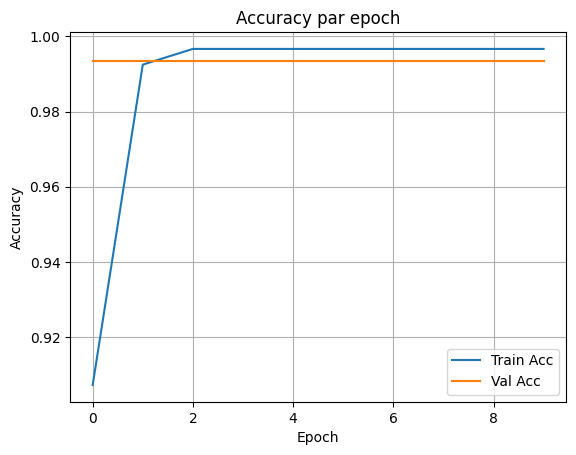

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# === PARAMÈTRES ===
img_size = 28
dataset_path = "roi_images"
classes = ["conforme", "non_conforme"]

# === CHARGEMENT DES IMAGES ===
X = []
y = []

for idx, label in enumerate(classes):
    class_folder = os.path.join(dataset_path, label)
    for file in os.listdir(class_folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            img_path = os.path.join(class_folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(idx)

X = np.array(X).reshape(-1, img_size, img_size, 1) / 255.0  # Normalisation
y = to_categorical(y, num_classes=2)

# === DIVISION TRAIN/TEST ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === MODELE CNN SIMPLE ===
model = Sequential([
    Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes
])

# === COMPILATION ===
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# === ENTRAINEMENT ===
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# === EVALUATION ===
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {accuracy:.2%}")
model.save("cnn_conformite_model.h5")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy par epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


### Extraction des roi en vue de test v1

In [2]:
import cv2
import os

# Chemin de l'image et du dossier de sortie
image_path = "dataset_binarized/train/conformes/30mm_WonB_1_resized_copy1_copy1_copy1.jpg"
output_dir = "extracted_rois"
coord_file = "coords.txt"

def extract_rois(image_path, output_dir, coord_file):
    # Charger l'image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"L'image '{image_path}' n'a pas été trouvée.")

    # Lire les coordonnées depuis le fichier
    with open(coord_file, "r") as f:
        coords = [tuple(map(int, line.strip().split(","))) for line in f]

    # Création du dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)

    # Extraction et sauvegarde des ROI
    for i, (x, y, w, h) in enumerate(coords):
        roi = image[y:y+h, x:x+w]
        roi_filename = f"roi_{i:02}.jpg"
        roi_path = os.path.join(output_dir, roi_filename)
        cv2.imwrite(roi_path, roi)
        print(f"ROI {i} sauvegardé sous '{roi_path}'")

# Exécuter l'extraction
extract_rois(image_path, output_dir, coord_file)

ROI 0 sauvegardé sous 'extracted_rois\roi_00.jpg'
ROI 1 sauvegardé sous 'extracted_rois\roi_01.jpg'
ROI 2 sauvegardé sous 'extracted_rois\roi_02.jpg'
ROI 3 sauvegardé sous 'extracted_rois\roi_03.jpg'
ROI 4 sauvegardé sous 'extracted_rois\roi_04.jpg'
ROI 5 sauvegardé sous 'extracted_rois\roi_05.jpg'
ROI 6 sauvegardé sous 'extracted_rois\roi_06.jpg'
ROI 7 sauvegardé sous 'extracted_rois\roi_07.jpg'
ROI 8 sauvegardé sous 'extracted_rois\roi_08.jpg'
ROI 9 sauvegardé sous 'extracted_rois\roi_09.jpg'
ROI 10 sauvegardé sous 'extracted_rois\roi_10.jpg'
ROI 11 sauvegardé sous 'extracted_rois\roi_11.jpg'
ROI 12 sauvegardé sous 'extracted_rois\roi_12.jpg'
ROI 13 sauvegardé sous 'extracted_rois\roi_13.jpg'
ROI 14 sauvegardé sous 'extracted_rois\roi_14.jpg'
ROI 15 sauvegardé sous 'extracted_rois\roi_15.jpg'
ROI 16 sauvegardé sous 'extracted_rois\roi_16.jpg'
ROI 17 sauvegardé sous 'extracted_rois\roi_17.jpg'
ROI 18 sauvegardé sous 'extracted_rois\roi_18.jpg'
ROI 19 sauvegardé sous 'extracted_rois\ro

### Test du model

In [59]:
import os
import sys
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# === PARAMÈTRES ===
IMG_SIZE = 28
MODEL_PATH = "cnn_conformite_model.h5"
CLASS_NAMES = ["conforme", "non_conforme"]

def load_and_prepare_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    return img.reshape(1, IMG_SIZE, IMG_SIZE, 1)

def main(folder_path):
    # Charger le modèle
    model = load_model(MODEL_PATH)

    # Parcourir toutes les images
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(folder_path, filename)
            img_input = load_and_prepare_image(filepath)

            if img_input is None:
                print(f"{filename} : image non valide")
                continue

            prediction = model.predict(img_input, verbose=0)
            class_index = np.argmax(prediction)
            confidence = prediction[0][class_index]

            if CLASS_NAMES[class_index] == "non_conforme" and confidence < 0.9:

                print(f"{filename} ➤ {CLASS_NAMES[class_index]} ({confidence:.2%}) ⚠️")
            else : 
                print(f"{filename} ➤ {CLASS_NAMES[class_index]} ({confidence:.2%}) ")

folder_path = "extracted_rois"
if os.path.isdir(folder_path):
    main(folder_path)
else:
    print("Erreur : le dossier n'existe pas.")
        


roi_01.png ➤ conforme (100.00%) 
roi_02.png ➤ conforme (100.00%) 
roi_03.png ➤ conforme (99.79%) 
roi_04.png ➤ conforme (100.00%) 
roi_05.png ➤ non_conforme (58.60%) ⚠️
roi_06.png ➤ conforme (100.00%) 
roi_07.png ➤ conforme (99.99%) 
roi_08.png ➤ conforme (100.00%) 
roi_09.png ➤ non_conforme (95.09%) 
roi_10.png ➤ conforme (100.00%) 
roi_11.png ➤ conforme (100.00%) 
roi_12.png ➤ conforme (100.00%) 
roi_13.png ➤ conforme (100.00%) 
roi_14.png ➤ non_conforme (99.92%) 
roi_15.png ➤ conforme (100.00%) 
roi_16.png ➤ conforme (100.00%) 
roi_17.png ➤ conforme (100.00%) 
roi_18.png ➤ conforme (100.00%) 
roi_19.png ➤ conforme (100.00%) 
roi_20.png ➤ conforme (99.99%) 
roi_21.png ➤ conforme (100.00%) 
roi_22.png ➤ conforme (100.00%) 
roi_23.png ➤ conforme (100.00%) 
roi_24.png ➤ conforme (98.55%) 
roi_25.png ➤ conforme (100.00%) 
roi_26.png ➤ conforme (99.99%) 
roi_27.png ➤ conforme (100.00%) 
roi_28.png ➤ conforme (99.98%) 
roi_29.png ➤ conforme (100.00%) 
roi_30.png ➤ conforme (100.00%) 
roi_3

### Binarisé une image 

In [ ]:
import cv2
import os
import numpy as np



def binarize_image(input_image_path, output_image_path):
    if not os.path.exists(input_image_path):
        print(f"Erreur : L'image d'entrée {input_image_path} n'existe pas.")
        exit()
    img = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Erreur : Impossible de charger l'image à {input_image_path}")
        exit()

    thresh_adaptive = cv2.adaptiveThreshold(
        img, 255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  
        cv2.THRESH_BINARY_INV,          
        11,                             
        2                               
    )
    _, thresh_otsu = cv2.threshold(
        img, 0, 255, 
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU  
    )

    thresh = thresh_adaptive
    cv2.imwrite(output_image_path, thresh)
    print(f"Image binarisée sauvegardée sous {output_image_path}")

    # Afficher l'image originale et l'image binarisée pour vérification
    cv2.imshow("Image originale (niveaux de gris)", img)
    cv2.imshow("Image binarisée", thresh)
    cv2.waitKey(0)  
    cv2.destroyAllWindows()


# Chemin de l'image d'entrée
input_image_path = "chiffre.jpg"
# Chemin pour sauvegarder l'image binarisée
output_image_path = "binarized_image.jpg"
binarize_image(input_image_path, output_image_path)

Image binarisée sauvegardée sous binarized_image.jpg


# Model de prédiction du chiffre manquant 

### Pré -traitrements : détection des positions des chiffres depuis une image provenant d un dxf 


In [ ]:
'data/dxf/dxf_clean_grand.png'

In [28]:
import cv2
import numpy as np

# Variable globale pour stocker les positions des clics
positions = []
rectangles = []  # Liste pour stocker les rectangles (début et fin)
drawing = False  # Indicateur de dessin
start_point = None  # Point de départ du rectangle

# Fonction de gestion des clics
def draw_rectangle(event, x, y, flags, param):
    global start_point, drawing, positions, rectangles, image

    if event == cv2.EVENT_LBUTTONDOWN:
        # Début du dessin
        drawing = True
        start_point = (x, y)

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            # Mettre à jour l'image temporairement pour montrer le rectangle en cours
            temp_image = image.copy()
            cv2.rectangle(temp_image, start_point, (x, y), (0, 255, 0), 2)
            cv2.imshow('Image', temp_image)

    elif event == cv2.EVENT_LBUTTONUP:
        # Fin du dessin
        drawing = False
        end_point = (x, y)
        rectangles.append((start_point, end_point))

        # Calculer le centre du rectangle
        center_x = (start_point[0] + end_point[0]) // 2
        center_y = (start_point[1] + end_point[1]) // 2
        positions.append((center_x, center_y))

        # Dessiner le rectangle sur l'image principale
        cv2.rectangle(image, start_point, end_point, (0, 255, 0), 2)
        cv2.imshow('Image', image)

        # Afficher les coordonnées dans la console
        print(f"Position {len(positions)}: (x={center_x}, y={center_y})")

# Charger l'image
image_path = 'image_rotated/30mm_WonB_5_resized.jpg'  # Remplacez par le chemin de votre image
image = cv2.imread(image_path)

# Vérifier si l'image est bien chargée
if image is None:
    print("Erreur : Impossible de charger l'image. Vérifiez le chemin.")
    exit()

# Convertir l'image en couleur si elle est en niveaux de gris
if len(image.shape) == 2:
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Obtenir les dimensions de l'image
h, w = image.shape[:2]

# Créer une fenêtre redimensionnable
cv2.namedWindow('Image', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('Image', draw_rectangle)

# Ajuster la taille de la fenêtre pour afficher l'image entière
max_width = 800
if w > max_width:
    ratio = max_width / w
    new_h = int(h * ratio)
    image = cv2.resize(image, (max_width, new_h))
    h, w = new_h, max_width

cv2.resizeWindow('Image', w, h)

# Afficher l'image et attendre les interactions
print("Cliquez et faites glisser pour entourer chaque chiffre. Appuyez sur 'q' pour quitter.")
while True:
    cv2.imshow('Image', image)
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  # Appuyez sur 'q' pour quitter
        break

# Fermer la fenêtre
cv2.destroyAllWindows()

# Afficher toutes les positions enregistrées
print("\nPositions finales :")
for i, (x, y) in enumerate(positions):
    print(f"Chiffre {i+1}: Position (x={x}, y={y})")

Cliquez et faites glisser pour entourer chaque chiffre. Appuyez sur 'q' pour quitter.
Position 1: (x=412, y=628)
Position 2: (x=451, y=625)
Position 3: (x=497, y=619)
Position 4: (x=537, y=593)
Position 5: (x=575, y=565)
Position 6: (x=601, y=530)
Position 7: (x=621, y=487)
Position 8: (x=638, y=444)
Position 9: (x=642, y=401)
Position 10: (x=633, y=353)
Position 11: (x=624, y=307)
Position 12: (x=596, y=271)
Position 13: (x=556, y=238)
Position 14: (x=525, y=207)
Position 15: (x=485, y=189)
Position 16: (x=436, y=180)
Position 17: (x=393, y=176)
Position 18: (x=351, y=185)
Position 19: (x=314, y=201)
Position 20: (x=282, y=240)
Position 21: (x=246, y=252)
Position 22: (x=218, y=299)
Position 23: (x=201, y=335)
Position 24: (x=189, y=383)
Position 25: (x=191, y=428)
Position 26: (x=200, y=471)
Position 27: (x=222, y=510)
Position 28: (x=245, y=550)
Position 29: (x=283, y=582)
Position 30: (x=320, y=611)
Position 31: (x=362, y=616)

Positions finales :
Chiffre 1: Position (x=412, y=628)

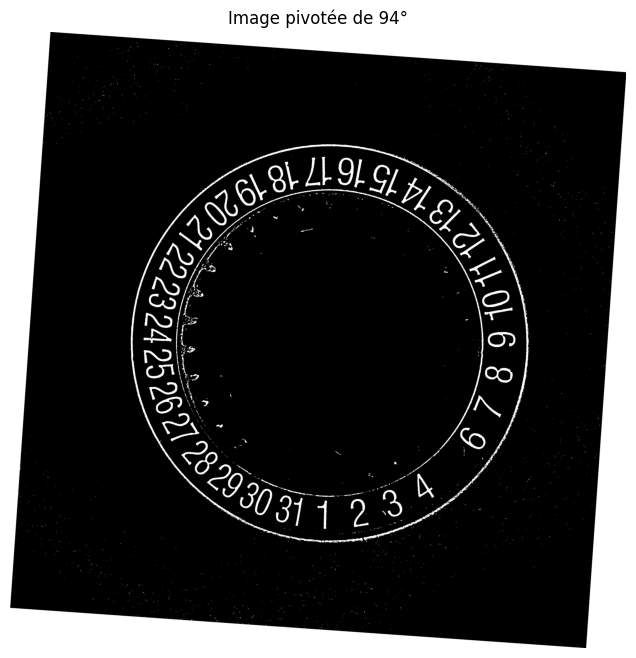

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Charger l'image
image_path = "dataset_binarized/train/non_conformes/30mm_WonB_5_resized_copy1_copy1_copy1.jpg"
image = cv2.imread(image_path)

# Vérifier que l'image est bien chargée
if image is None:
    print("Erreur : image introuvable.")
else:
    # Obtenir les dimensions de l'image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Créer la matrice de rotation (angle horaire = -94°)
    angle = -94  # vers la droite
    scale = 1.0
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, scale)

    # Calculer la nouvelle taille
    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adapter la matrice pour centrer l'image pivotée
    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    # Appliquer la rotation
    rotated = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderValue=(255, 255, 255))

    # Convertir BGR -> RGB pour matplotlib
    rotated_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)

    # Afficher avec matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(rotated_rgb)
    plt.title("Image pivotée de 94°")
    plt.axis("off")
    plt.show()


In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

def rotate_image(image, angle=-94):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

    cos = np.abs(rotation_matrix[0, 0])
    sin = np.abs(rotation_matrix[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    rotation_matrix[0, 2] += (new_w / 2) - center[0]
    rotation_matrix[1, 2] += (new_h / 2) - center[1]

    rotated = cv2.warpAffine(image, rotation_matrix, (new_w, new_h), borderValue=(255, 255, 255))
    return rotated

def process_folder(source_dir, dest_dir, show=False):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            src_path = os.path.join(source_dir, filename)
            dst_path = os.path.join(dest_dir, filename)

            image = cv2.imread(src_path)
            if image is None:
                print(f"Erreur de lecture : {src_path}")
                continue

            rotated = rotate_image(image)

            # Sauvegarde de l'image pivotée
            cv2.imwrite(dst_path, rotated)
            print(f"Image enregistrée : {dst_path}")

            # Optionnel : affichage (1 seule fois par image)
            if show:
                rotated_rgb = cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB)
                plt.imshow(rotated_rgb)
                plt.title(f"Pivotée: {filename}")
                plt.axis("off")
                plt.show()

# Utilisation
source_folder = "dataset"
destination_folder = "image_rotated"
process_folder(source_folder, destination_folder, show=False)
